In [1]:
from transformers import AutoModel, AutoTokenizer
import torch
torch.manual_seed(0)

path = '/home/guodewen/research/IRTrain/models/minicpm-2b-dpo'
tokenizer = AutoTokenizer.from_pretrained(path)
model = AutoModel.from_pretrained(path, torch_dtype=torch.bfloat16, device_map='cuda', trust_remote_code=True)

# responds, history = model.chat(tokenizer, "山东省最高的山是哪座山, 它比黄山高还是矮？差距多少？", temperature=0.8, top_p=0.8)
# print(responds)
inputs = tokenizer.batch_encode_plus(['''Retrieval plays a fundamental role in recommendation systems, search, and natural language processing. happy, role, role, role , Dot products have been widely used as the similarity function in such retrieval tasks. Do you Know I am Not Happy.'''], return_tensors='pt').to('cuda')
ret = model(**inputs)
print(ret.last_hidden_state)

/home/guodewen/miniconda3/envs/stella/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/guodewen/miniconda3/envs/stella/lib/python3.8/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/guodewen/miniconda3/envs/stella/lib/python3.8/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/guodewen/miniconda3/envs/stella/lib/python3.8/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. 

tensor([[[ -3.0000,  -5.1875,   9.0625,  ...,  -5.6875,  -4.5000,   4.0938],
         [ -0.5469, -11.5000,  -6.6875,  ...,   0.8516,   0.0310,   1.3750],
         [  7.5625, -10.8125,  -3.2344,  ...,  -1.2188,  -2.5000,   2.7812],
         ...,
         [ -5.7188, -11.3125,   0.3418,  ...,  -1.9688,   3.1562,  -6.8750],
         [  0.3730,  -6.1875,   0.5352,  ...,   1.6719,   0.9922,   4.1562],
         [ -6.3438,  -4.5625,   2.5312,  ...,  -3.7656,   2.4062,   4.6875]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<MulBackward0>)
tensor([[[ -3.0000,  -5.1875,   9.0625,  ...,  -5.6875,  -4.5000,   4.0938],
         [ -0.5469, -11.5000,  -6.6875,  ...,   0.8516,   0.0310,   1.3750],
         [  7.5625, -10.8125,  -3.2344,  ...,  -1.2188,  -2.5000,   2.7812],
         ...,
         [ -5.7188, -11.3125,   0.3418,  ...,  -1.9688,   3.1562,  -6.8750],
         [  0.3730,  -6.1875,   0.5352,  ...,   1.6719,   0.9922,   4.1562],
         [ -6.3438,  -4.5625,   2.5312,  ...,  -3.765

torch.Size([2304, 49])


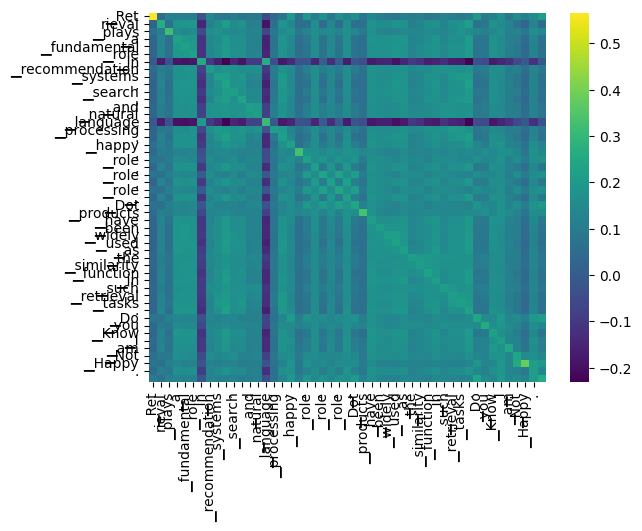

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# # 设置字体为SimHei（黑体）以支持中文显示
# plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # 指定默认字体
# plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# sns.set_style('whitegrid',{'font.sans-serif':['DejaVu Sans',]})

# print(weights.shape)
# 选择一个特定的隐藏层权重
weights = ret.last_hidden_state[0]
print(weights.T.shape)
weights = torch.matmul(weights,  weights.T)
weights = torch.nn.functional.normalize(weights, 2.0, dim=1)
weights = weights.float().cpu().detach().numpy()

idx = inputs['input_ids'].tolist()
decoded_text = tokenizer.convert_ids_to_tokens(idx[0])[1:]

# 绘制热力图
plt.figure()
sns.heatmap(weights, cmap="viridis", 
            xticklabels=decoded_text,
            yticklabels=decoded_text,
            )


# sns.set_xticklabels(decoded_text)
plt.show()

[0.56640625 0.26171875 0.3203125  0.22167969 0.22558594 0.22558594
 0.25390625 0.2109375  0.21679688 0.23046875 0.2109375  0.23144531
 0.21679688 0.21582031 0.30859375 0.21289062 0.21484375 0.21875
 0.328125   0.2265625  0.21191406 0.24023438 0.21777344 0.23730469
 0.21582031 0.24121094 0.33398438 0.20996094 0.20996094 0.21191406
 0.2265625  0.20898438 0.2109375  0.20996094 0.22167969 0.20898438
 0.20898438 0.20996094 0.21386719 0.22949219 0.24121094 0.25585938
 0.22167969 0.20800781 0.24414062 0.23925781 0.3828125  0.21582031
 0.25976562]


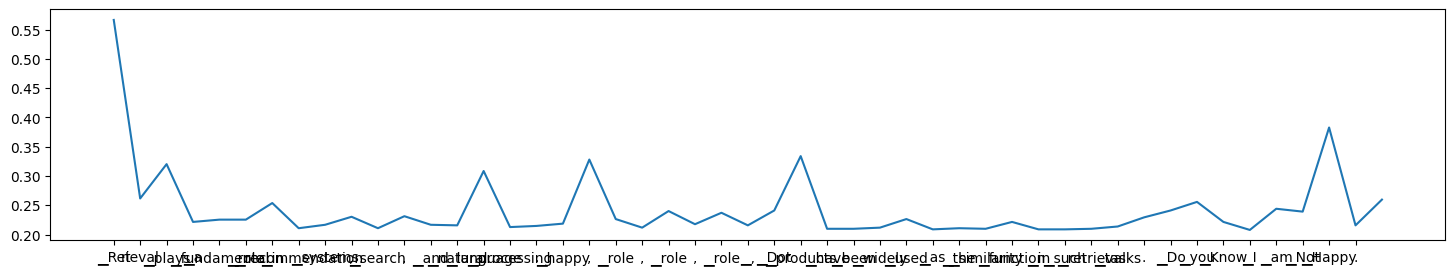

In [3]:
asss = np.diag(weights)
print(asss)
plt.figure(figsize=(18, 3))
ans = torch.cumsum(torch.tensor(asss), 0).numpy()
plt.plot(asss)

# 获取当前坐标轴对象
ax = plt.gca()

# # 自定义x轴刻度
# print(asss.shape)
# print(len(decoded_text))
ax.set_xticks([i for i in range(len(asss)-1)])
ax.set_xticklabels(decoded_text)
# plt.xticks(ticks=, labels=)
plt.show()

torch.Size([49, 49])


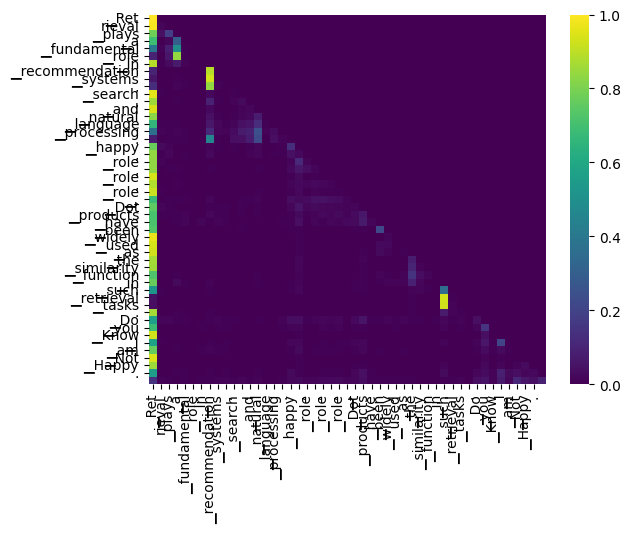

In [6]:
print(ret.attentions[-1][-1][-1].shape)
attn = ret.attentions[-1][-1][-1].float().cpu().detach().numpy()

# 绘制热力图
plt.figure()
sns.heatmap(attn, cmap="viridis", 
            xticklabels=decoded_text,
            yticklabels=decoded_text,
            )
# sns.set_xticklabels(decoded_text)
plt.show()